In [ ]:
# Paired test (simplest case)
#Let’s say you just want Baseline (0) vs D30 (2) comparison for each protein.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# Load your file
df = pd.read_csv("NPXpp_with_timecode.csv")
print(" File read")

 File read


In [2]:
feature_cols = [c for c in df.columns if c not in ['SampleID', 'Timepoint']]
# Ensure numeric
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Check for NaNs
if df[feature_cols].isna().sum().sum() > 0:
    raise ValueError("There are NaN values in your protein data!")

# Check for Inf
if np.isinf(df[feature_cols].values).any():
    raise ValueError("There are Inf values in your protein data!")


# PCA

C:\Users\mondalsy\AppData\Local\Temp\ipykernel_27540\2839297282.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PC1'] = X_pca[:,0]
C:\Users\mondalsy\AppData\Local\Temp\ipykernel_27540\2839297282.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PC2'] = X_pca[:,1]
C:\Users\mondalsy\AppData\Local\Temp\ipykernel_27540\2839297282.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

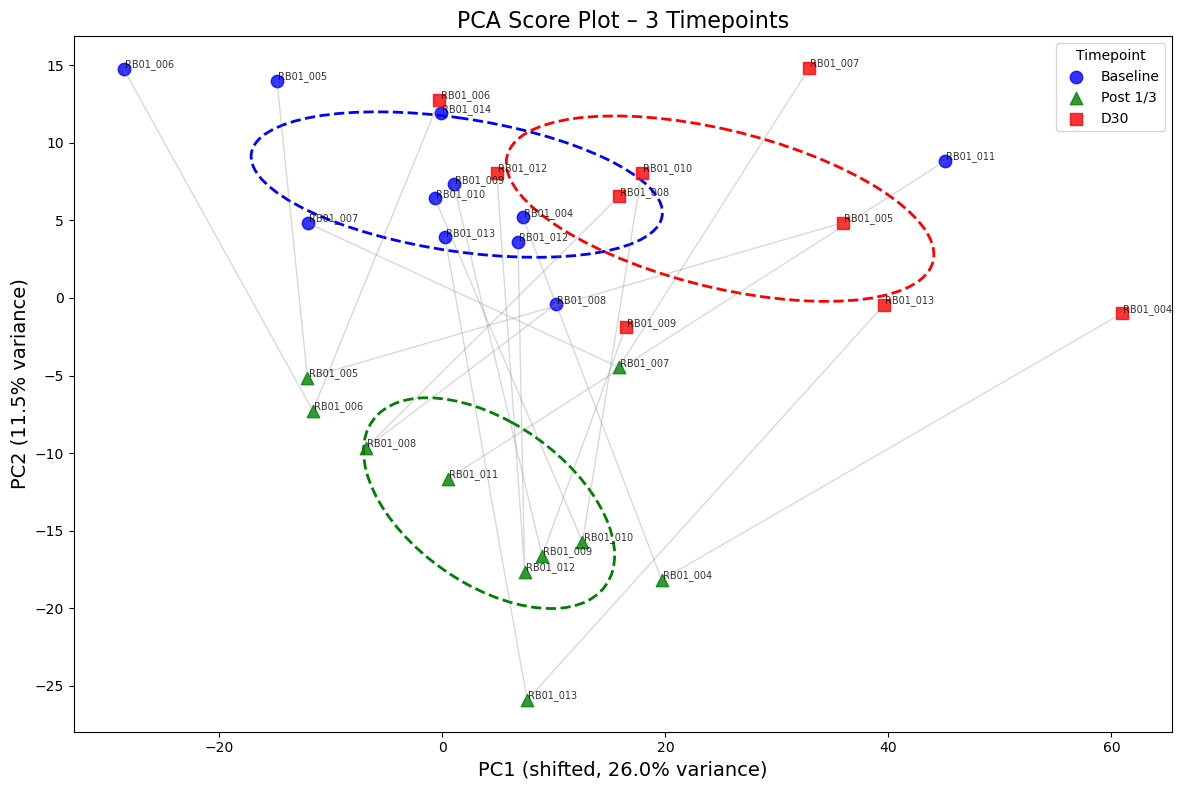

In [11]:

df['Timepoint'] = df['Timepoint'].astype(int)

# Select protein columns
feature_cols = [c for c in df.columns if c not in ['SampleID', 'Timepoint']]

# Scale features
X_scaled = StandardScaler().fit_transform(df[feature_cols])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# Explained variance
expl_var = pca.explained_variance_ratio_ * 100

# Optional: numeric spacing by timepoint (like R example)
time_offsets = {0:0, 1:10, 2:20}
df['PC1_shifted'] = df['PC1'] + df['Timepoint'].map(time_offsets)

# Colors & markers
colors = {0:'blue', 1:'green', 2:'red'}
markers = {0:'o', 1:'^', 2:'s'}
labels = {0:'Baseline', 1:'Post 1/3', 2:'D30'}

plt.figure(figsize=(12,8))

# Plot points by timepoint with legend labels
for t in sorted(df['Timepoint'].unique()):
    subset = df[df['Timepoint']==t]
    plt.scatter(subset['PC1_shifted'], subset['PC2'],
                color=colors[t], marker=markers[t], s=80,
                alpha=0.8, label=labels[t])

    # Draw ellipse (1 std)
    cov = np.cov(subset[['PC1_shifted','PC2']].T)
    mean = subset[['PC1_shifted','PC2']].mean().values
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:,order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2*np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[t], fc='none', lw=2, ls='--')
    plt.gca().add_patch(ellipse)

# Connect same subject across timepoints

# Connect same subject across timepoints and annotate
for sample_id in df['SampleID'].unique():
    sub = df[df['SampleID']==sample_id].sort_values('Timepoint')
    plt.plot(sub['PC1_shifted'], sub['PC2'], color='gray', alpha=0.3, linewidth=1)
    
    # Annotate each sample point with its SampleID
    for _, row in sub.iterrows():
        plt.text(row['PC1_shifted']+0.1, row['PC2']+0.1, row['SampleID'],
                 fontsize=7, alpha=0.8)

plt.xlabel(f'PC1 (shifted, {expl_var[0]:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({expl_var[1]:.1f}% variance)', fontsize=14)
plt.title('PCA Score Plot – 3 Timepoints', fontsize=16)
plt.legend(title="Timepoint")
plt.grid(False)
plt.tight_layout()
plt.show()


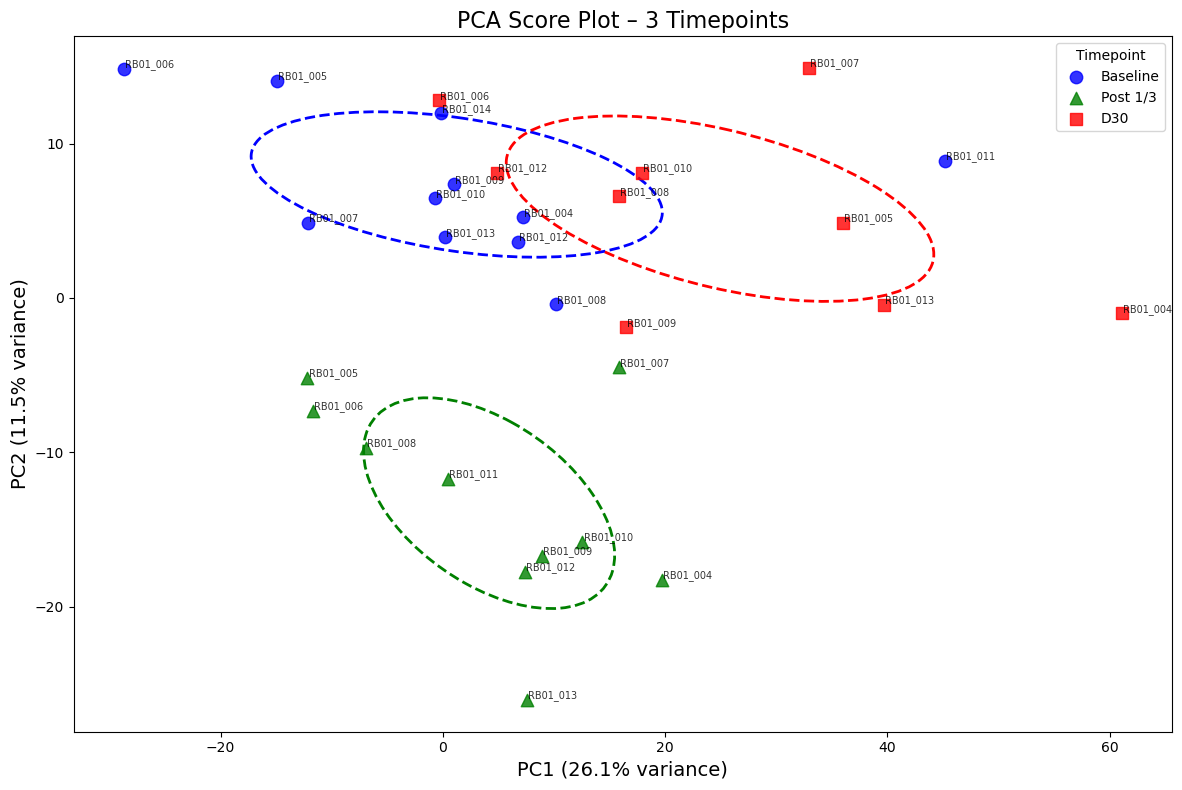

In [16]:


df['Timepoint'] = df['Timepoint'].astype(int)

# Select protein columns
feature_cols = [c for c in df.columns if c not in ['SampleID', 'Timepoint']]

# Scale features
X_scaled = StandardScaler().fit_transform(df[feature_cols])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# Explained variance
expl_var = pca.explained_variance_ratio_ * 100

# Optional: numeric spacing by timepoint
time_offsets = {0:0, 1:10, 2:20}
df['PC1_shifted'] = df['PC1'] + df['Timepoint'].map(time_offsets)

# Colors & markers
colors = {0:'blue', 1:'green', 2:'red'}
markers = {0:'o', 1:'^', 2:'s'}
labels = {0:'Baseline', 1:'Post 1/3', 2:'D30'}

plt.figure(figsize=(12,8))

# Plot points by timepoint with ellipses
for t in sorted(df['Timepoint'].unique()):
    subset = df[df['Timepoint']==t]
    plt.scatter(subset['PC1_shifted'], subset['PC2'],
                color=colors[t], marker=markers[t], s=80,
                alpha=0.8, label=labels[t])

    # Draw ellipse (1 std)
    cov = np.cov(subset[['PC1_shifted','PC2']].T)
    mean = subset[['PC1_shifted','PC2']].mean().values
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:,order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2*np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[t], fc='none', lw=2, ls='--')
    plt.gca().add_patch(ellipse)

# Annotate each sample point
for _, row in df.iterrows():
    plt.text(row['PC1_shifted']+0.1, row['PC2']+0.1, row['SampleID'],
             fontsize=7, alpha=0.8)

plt.xlabel(f'PC1 ({expl_var[0]:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({expl_var[1]:.1f}% variance)', fontsize=14)
plt.title('PCA Score Plot – 3 Timepoints', fontsize=16)
plt.legend(title="Timepoint")
plt.grid(False)
plt.tight_layout()
plt.show()


Total proteins tested: 1034
Significant proteins (p < 0.05): 129
     Protein  mean_diff   p_value
12    ADAM12   1.222422  0.000309
228  COL24A1   0.962000  0.000318
403    GFRA1   0.423544  0.000755
324   EIF4E2  -0.319467  0.000771
968  TNFSF13   0.260033  0.000781
..       ...        ...       ...
738  PLA2G10   0.379378  0.048492
222   CLSTN3   0.372111  0.049572
492  IL18RAP  -0.223300  0.049778
546  KIR3DL1   0.271356  0.049933
590      LTK   0.208633  0.049986

[129 rows x 3 columns]


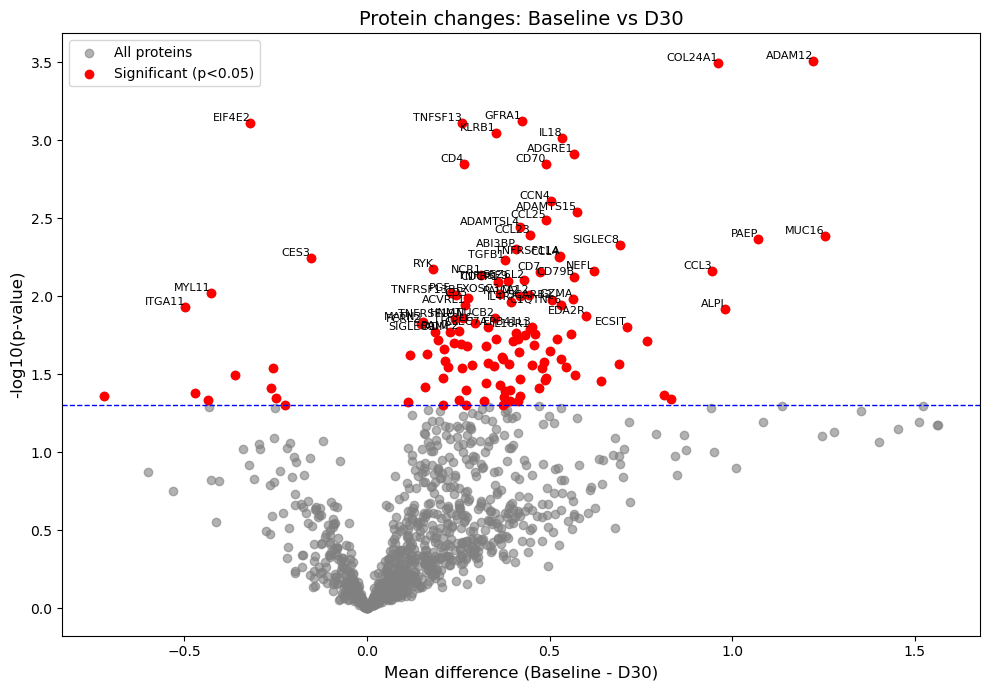

In [4]:
# t test 

# Keep only Baseline (0) and D30 (2)
baseline = df[df['Timepoint'] == 0]
d30 = df[df['Timepoint'] == 2]

# Align by SampleID
merged = pd.merge(baseline, d30, on='SampleID', suffixes=('_base', '_d30'))

# Perform paired t-test for each protein
results = []
for col in df.columns:
    if col not in ['SampleID', 'Timepoint']:
        stat, p = ttest_rel(merged[f'{col}_base'], merged[f'{col}_d30'])
        mean_diff = merged[f'{col}_d30'].mean() - merged[f'{col}_base'].mean()
        results.append({'Protein': col, 'mean_diff': mean_diff, 'p_value': p})

results_df = pd.DataFrame(results)

# Keep only significant proteins (raw p < 0.05)
sig_results = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

# Save significant results
sig_results.to_csv("NPXpp_D30Base_significant.csv", index=False)

# Print summary
print(f"Total proteins tested: {len(results_df)}")
print(f"Significant proteins (p < 0.05): {len(sig_results)}")
print(sig_results)

# Volcano-style plot
plt.figure(figsize=(10,7))
plt.scatter(results_df['mean_diff'], -np.log10(results_df['p_value']),
            color='gray', alpha=0.6, label='All proteins')

plt.scatter(sig_results['mean_diff'], -np.log10(sig_results['p_value']),
            color='red', label='Significant (p<0.05)')

# Label only top 50 most significant proteins
top50 = sig_results.nsmallest(60, 'p_value')
for _, row in top50.iterrows():
    plt.text(row['mean_diff'], -np.log10(row['p_value']), row['Protein'],
             fontsize=8, ha='right', va='bottom')

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.xlabel('Mean difference (Baseline - D30)', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.title('Protein changes: Baseline vs D30', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

Total proteins tested: 1034
Significant proteins after FDR (p<0.05): 0
Empty DataFrame
Columns: [Protein, mean_diff, p_value, p_FDR, Sig_FDR]
Index: []


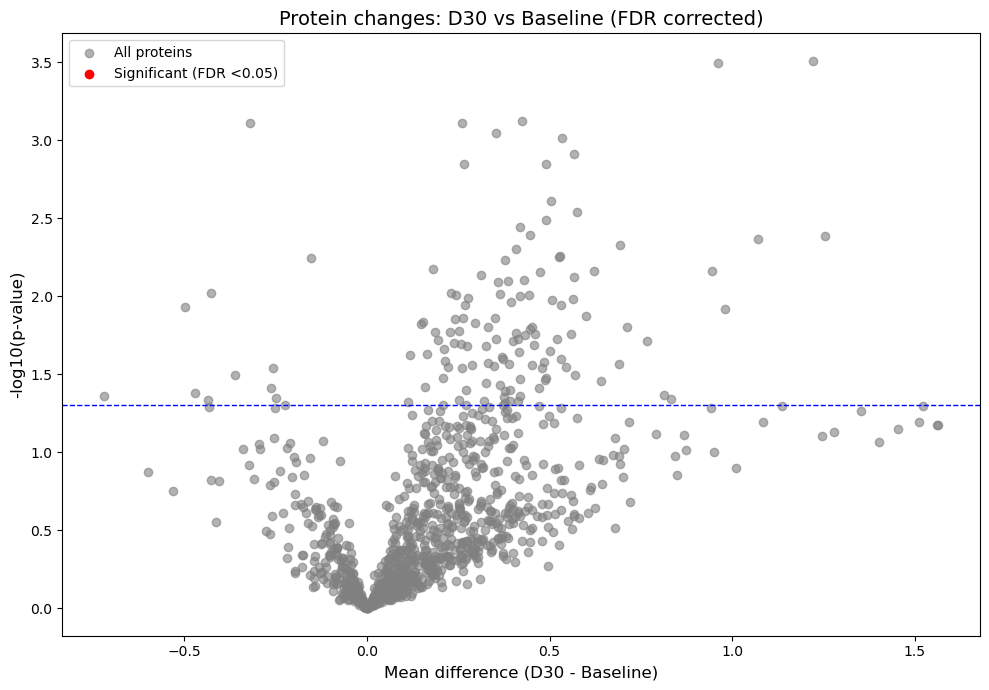

In [2]:
# try FDR after sig

from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Keep only Baseline (0) and D30 (2)
baseline = df[df['Timepoint'] == 0]
d30 = df[df['Timepoint'] == 2]

# Align by SampleID
merged = pd.merge(baseline, d30, on='SampleID', suffixes=('_base', '_d30'))

# Perform paired t-test for each protein
results = []
for col in df.columns:
    if col not in ['SampleID', 'Timepoint']:
        stat, p = ttest_rel(merged[f'{col}_base'], merged[f'{col}_d30'])
        mean_diff = merged[f'{col}_d30'].mean() - merged[f'{col}_base'].mean()
        results.append({'Protein': col, 'mean_diff': mean_diff, 'p_value': p})

results_df = pd.DataFrame(results)

# Apply FDR correction
_, p_fdr, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
results_df['p_FDR'] = p_fdr
results_df['Sig_FDR'] = results_df['p_FDR'] < 0.05

# Keep only significant proteins after FDR
sig_results = results_df[results_df['Sig_FDR']].sort_values('p_FDR')

# Save significant results
sig_results.to_csv("NPXpp_significant_FDR.csv", index=False)

# Print summary
print(f"Total proteins tested: {len(results_df)}")
print(f"Significant proteins after FDR (p<0.05): {len(sig_results)}")
print(sig_results.head())

# Volcano plot
plt.figure(figsize=(10,7))
plt.scatter(results_df['mean_diff'], -np.log10(results_df['p_value']),
            color='gray', alpha=0.6, label='All proteins')

plt.scatter(sig_results['mean_diff'], -np.log10(sig_results['p_value']),
            color='red', label='Significant (FDR <0.05)')

# Label top 50 most significant proteins
top50 = sig_results.nsmallest(50, 'p_FDR')
for _, row in top50.iterrows():
    plt.text(row['mean_diff'], -np.log10(row['p_value']), row['Protein'],
             fontsize=8, ha='right', va='bottom')

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.xlabel('Mean difference (D30 - Baseline)', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.title('Protein changes: D30 vs Baseline (FDR corrected)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Total proteins tested: 1034
Significant proteins (p < 0.05): 388
     Protein  mean_diff       p_value
504     IL32   -0.55388  6.069893e-07
360    FCRL6   -0.41725  1.391245e-06
571   LEFTY2   -1.06346  2.148095e-06
146    CCL23    1.42141  2.862700e-06
288     DKK4   -1.12409  2.942474e-06
...      ...        ...           ...
171     CD38    0.29624  4.742917e-02
457      IDS   -0.09155  4.769067e-02
437    HLA-A   -0.14858  4.786436e-02
1008    VNN2    0.39570  4.808765e-02
335    EPHB6   -0.19079  4.862340e-02

[388 rows x 3 columns]


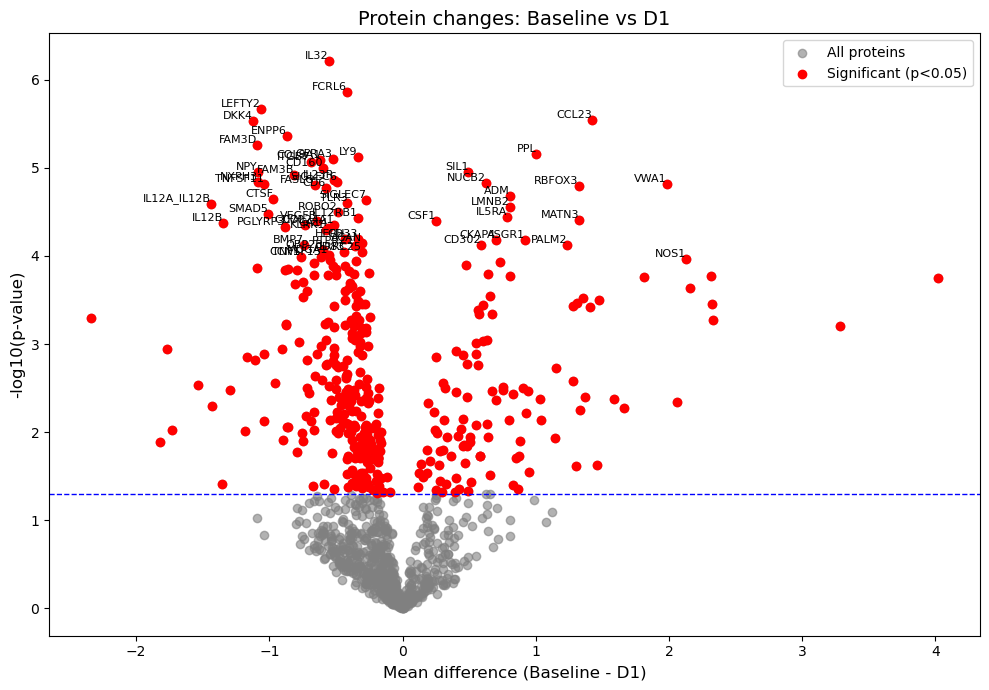

In [3]:
# 2

# Keep only Baseline (0) and D30 (2)
baseline = df[df['Timepoint'] == 0]
d30 = df[df['Timepoint'] == 1]

# Align by SampleID
merged = pd.merge(baseline, d30, on='SampleID', suffixes=('_base', '_d30'))

# Perform paired t-test for each protein
results = []
for col in df.columns:
    if col not in ['SampleID', 'Timepoint']:
        stat, p = ttest_rel(merged[f'{col}_base'], merged[f'{col}_d30'])
        mean_diff = merged[f'{col}_d30'].mean() - merged[f'{col}_base'].mean()
        results.append({'Protein': col, 'mean_diff': mean_diff, 'p_value': p})

results_df = pd.DataFrame(results)

# Keep only significant proteins (raw p < 0.05)
sig_results = results_df[results_df['p_value'] < 0.05].sort_values('p_value')

# Save significant results
sig_results.to_csv("NPXpp_BaseD1significant.csv", index=False)

# Print summary
print(f"Total proteins tested: {len(results_df)}")
print(f"Significant proteins (p < 0.05): {len(sig_results)}")
print(sig_results)

# Volcano-style plot
plt.figure(figsize=(10,7))
plt.scatter(results_df['mean_diff'], -np.log10(results_df['p_value']),
            color='gray', alpha=0.6, label='All proteins')

plt.scatter(sig_results['mean_diff'], -np.log10(sig_results['p_value']),
            color='red', label='Significant (p<0.05)')

# Label only top 50 most significant proteins
top50 = sig_results.nsmallest(60, 'p_value')
for _, row in top50.iterrows():
    plt.text(row['mean_diff'], -np.log10(row['p_value']), row['Protein'],
             fontsize=8, ha='right', va='bottom')

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.xlabel('Mean difference (Baseline - D1)', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.title('Protein changes: Baseline vs D1', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


Total proteins tested: 1034
Significant proteins after FDR (p<0.05): 298
    Protein  mean_diff       p_value     p_FDR  Sig_FDR
504    IL32   -0.55388  6.069893e-07  0.000609     True
571  LEFTY2   -1.06346  2.148095e-06  0.000609     True
146   CCL23    1.42141  2.862700e-06  0.000609     True
288    DKK4   -1.12409  2.942474e-06  0.000609     True
360   FCRL6   -0.41725  1.391245e-06  0.000609     True


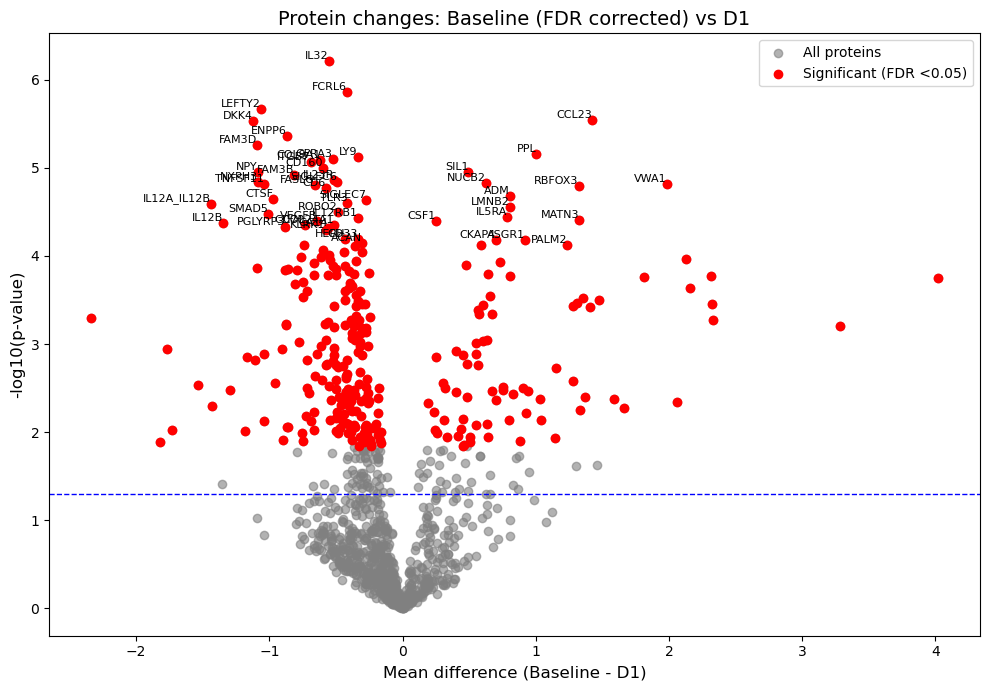

In [4]:
# try FDR after sig

from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Keep only Baseline (0) and D30 (2)
baseline = df[df['Timepoint'] == 0]
d30 = df[df['Timepoint'] == 1]

# Align by SampleID
merged = pd.merge(baseline, d30, on='SampleID', suffixes=('_base', '_d30'))

# Perform paired t-test for each protein
results = []
for col in df.columns:
    if col not in ['SampleID', 'Timepoint']:
        stat, p = ttest_rel(merged[f'{col}_base'], merged[f'{col}_d30'])
        mean_diff = merged[f'{col}_d30'].mean() - merged[f'{col}_base'].mean()
        results.append({'Protein': col, 'mean_diff': mean_diff, 'p_value': p})

results_df = pd.DataFrame(results)

# Apply FDR correction
_, p_fdr, _, _ = multipletests(results_df['p_value'], alpha=0.05, method='fdr_bh')
results_df['p_FDR'] = p_fdr
results_df['Sig_FDR'] = results_df['p_FDR'] < 0.05

# Keep only significant proteins after FDR
sig_results = results_df[results_df['Sig_FDR']].sort_values('p_FDR')

# Save significant results
sig_results.to_csv("NPXpp_Baseline(FDR corrected)D1significant_FDR.csv", index=False)

# Print summary
print(f"Total proteins tested: {len(results_df)}")
print(f"Significant proteins after FDR (p<0.05): {len(sig_results)}")
print(sig_results.head())

# Volcano plot
plt.figure(figsize=(10,7))
plt.scatter(results_df['mean_diff'], -np.log10(results_df['p_value']),
            color='gray', alpha=0.6, label='All proteins')

plt.scatter(sig_results['mean_diff'], -np.log10(sig_results['p_value']),
            color='red', label='Significant (FDR <0.05)')

# Label top 50 most significant proteins
top50 = sig_results.nsmallest(50, 'p_FDR')
for _, row in top50.iterrows():
    plt.text(row['mean_diff'], -np.log10(row['p_value']), row['Protein'],
             fontsize=8, ha='right', va='bottom')

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.xlabel('Mean difference (Baseline - D1)', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.title('Protein changes: Baseline (FDR corrected) vs D1', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


# pairwise comparisons (0→2, 0→1, 1→2)

In [ ]:
# we have 3 timepoints (0, 1, 2) per subject
# Friedman test (non-parametric repeated-measures ANOVA):

Total proteins tested: 1034
Significant Friedman (p<0.05): 399
Significant in any pairwise test (p<0.05): 459


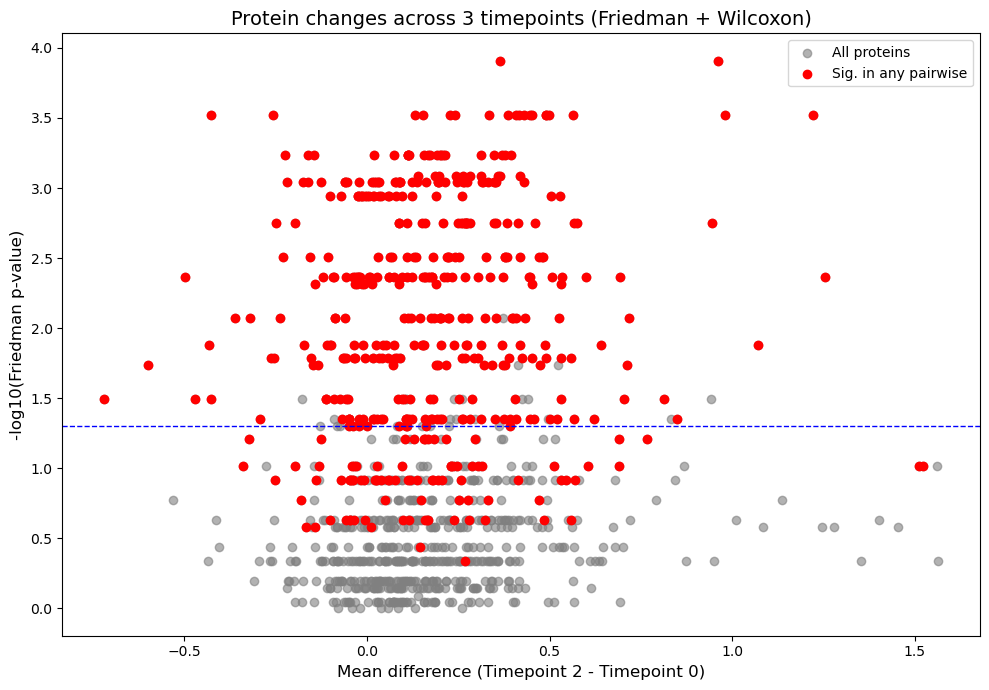

In [21]:

# Ensure Timepoint is integer
df['Timepoint'] = df['Timepoint'].astype(int)

results = []

# Loop over all protein columns
for col in df.columns:
    if col not in ['SampleID', 'Timepoint']:
        wide = df.pivot(index='SampleID', columns='Timepoint', values=col)

        # Check that all three timepoints exist
        if not all(t in wide.columns for t in [0, 1, 2]):
            continue

        # Drop rows with missing values
        wide = wide.dropna()

        # Friedman test (overall across all 3)
        try:
            stat, p_friedman = friedmanchisquare(wide[0], wide[1], wide[2])
        except ValueError:
            continue

        # Pairwise Wilcoxon signed-rank tests
        try:
            p_01 = wilcoxon(wide[0], wide[1]).pvalue
        except ValueError:
            p_01 = np.nan
        try:
            p_02 = wilcoxon(wide[0], wide[2]).pvalue
        except ValueError:
            p_02 = np.nan
        try:
            p_12 = wilcoxon(wide[1], wide[2]).pvalue
        except ValueError:
            p_12 = np.nan

        mean_diff_02 = wide[2].mean() - wide[0].mean()
        mean_diff_01 = wide[1].mean() - wide[0].mean()
        mean_diff_12 = wide[2].mean() - wide[1].mean()

        results.append({
            'Protein': col,
            'p_Friedman': p_friedman,
            'p_01': p_01,
            'p_02': p_02,
            'p_12': p_12,
            'mean_diff_01': mean_diff_01,
            'mean_diff_12': mean_diff_12,
            'mean_diff_02': mean_diff_02
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by Friedman p-value
results_df = results_df.sort_values('p_Friedman')

# Optional significance flags
results_df['Sig_Friedman'] = results_df['p_Friedman'] < 0.05
results_df['Sig_Any_Pairwise'] = (
    (results_df[['p_01', 'p_02', 'p_12']] < 0.05).any(axis=1)
)

# Save
results_df.to_csv("friedman_posthoc_results.csv", index=False)

# Print summary
print(f"Total proteins tested: {len(results_df)}")
print(f"Significant Friedman (p<0.05): {results_df['Sig_Friedman'].sum()}")
print(f"Significant in any pairwise test (p<0.05): {results_df['Sig_Any_Pairwise'].sum()}")

# Volcano-style plot (using 0→2 difference)
plt.figure(figsize=(10,7))
plt.scatter(results_df['mean_diff_02'], -np.log10(results_df['p_Friedman']),
            color='gray', alpha=0.6, label='All proteins')

sig = results_df[results_df['Sig_Any_Pairwise']]
plt.scatter(sig['mean_diff_02'], -np.log10(sig['p_Friedman']),
            color='red', label='Sig. in any pairwise')

plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.xlabel('Mean difference (Timepoint 2 - Timepoint 0)', fontsize=12)
plt.ylabel('-log10(Friedman p-value)', fontsize=12)
plt.title('Protein changes across 3 timepoints (Friedman + Wilcoxon)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
sig_proteins = results_df[results_df['Sig_Friedman']]
len(sig_proteins)

399

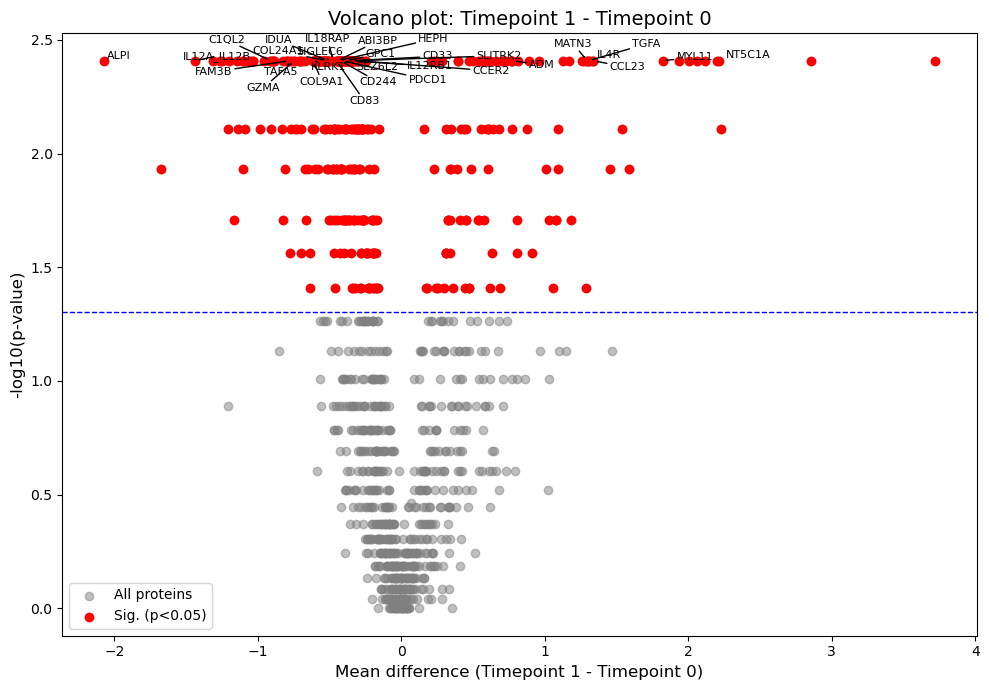

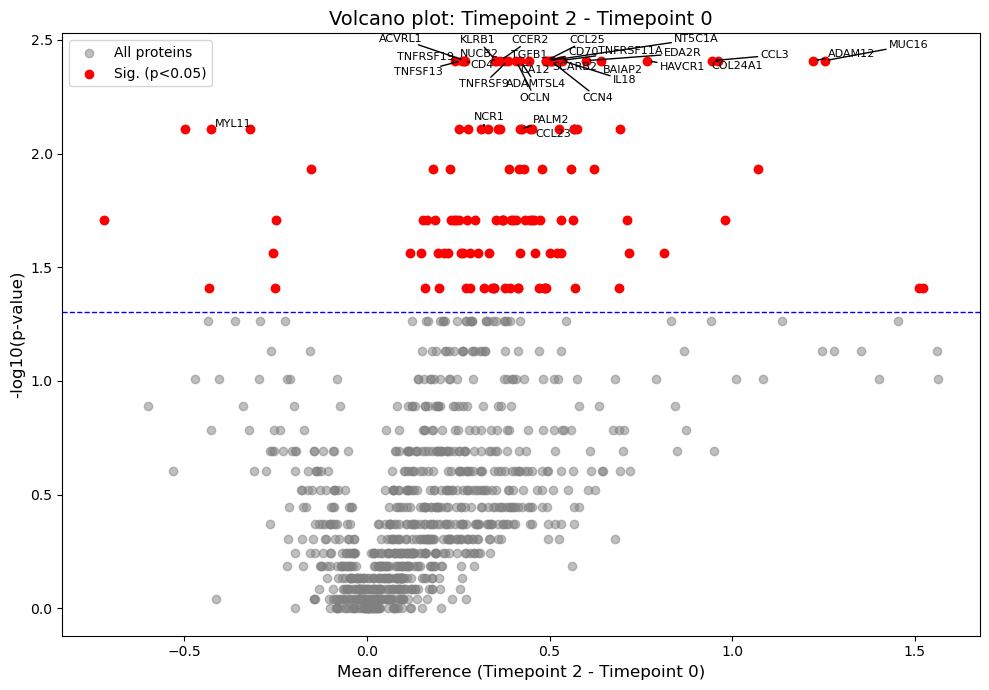

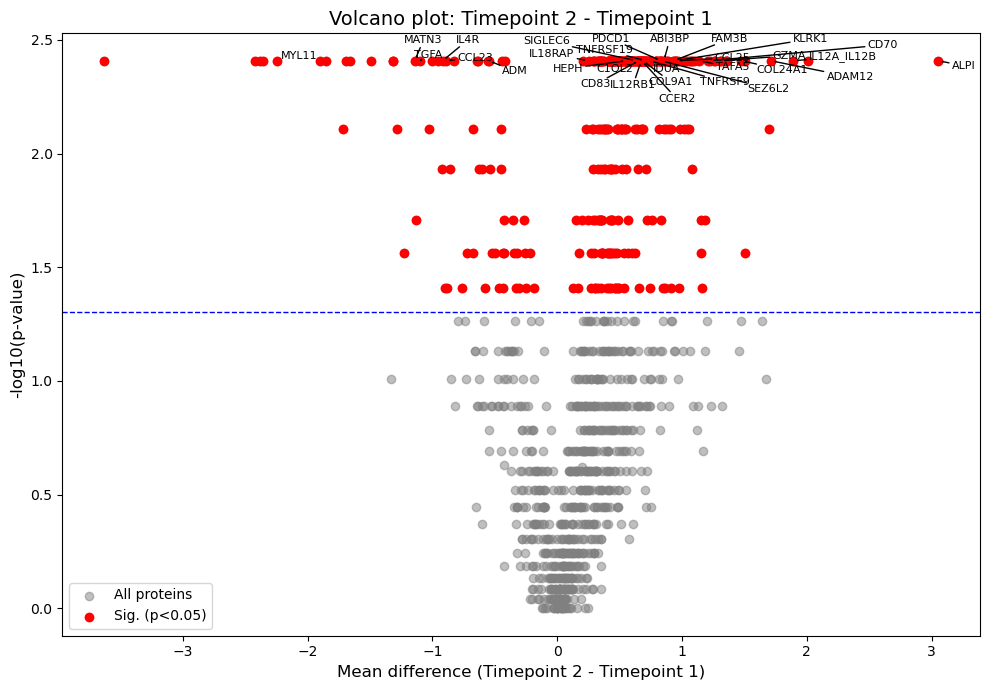

In [22]:
from adjustText import adjust_text

# Define comparisons
comparisons = [
    ('p_01', 'mean_diff_01', 'Timepoint 1 - Timepoint 0'),
    ('p_02', 'mean_diff_02', 'Timepoint 2 - Timepoint 0'),
    ('p_12', 'mean_diff_12', 'Timepoint 2 - Timepoint 1')
]

for p_col, diff_col, label in comparisons:
    df_plot = results_df.dropna(subset=[p_col, diff_col])
    
    # Significant proteins
    sig = df_plot[df_plot[p_col] < 0.05]
    
    plt.figure(figsize=(10,7))
    plt.scatter(df_plot[diff_col], -np.log10(df_plot[p_col]), color='gray', alpha=0.5, label='All proteins')
    plt.scatter(sig[diff_col], -np.log10(sig[p_col]), color='red', label='Sig. (p<0.05)')
    
    # Label top 40 significant proteins with adjustText
    top_sig = sig.nsmallest(30, p_col)
    texts = []
    for _, row in top_sig.iterrows():
        texts.append(plt.text(row[diff_col], -np.log10(row[p_col]), row['Protein'], fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
    plt.xlabel(f'Mean difference ({label})', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title(f'Volcano plot: {label}', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


# extra for FDR plot

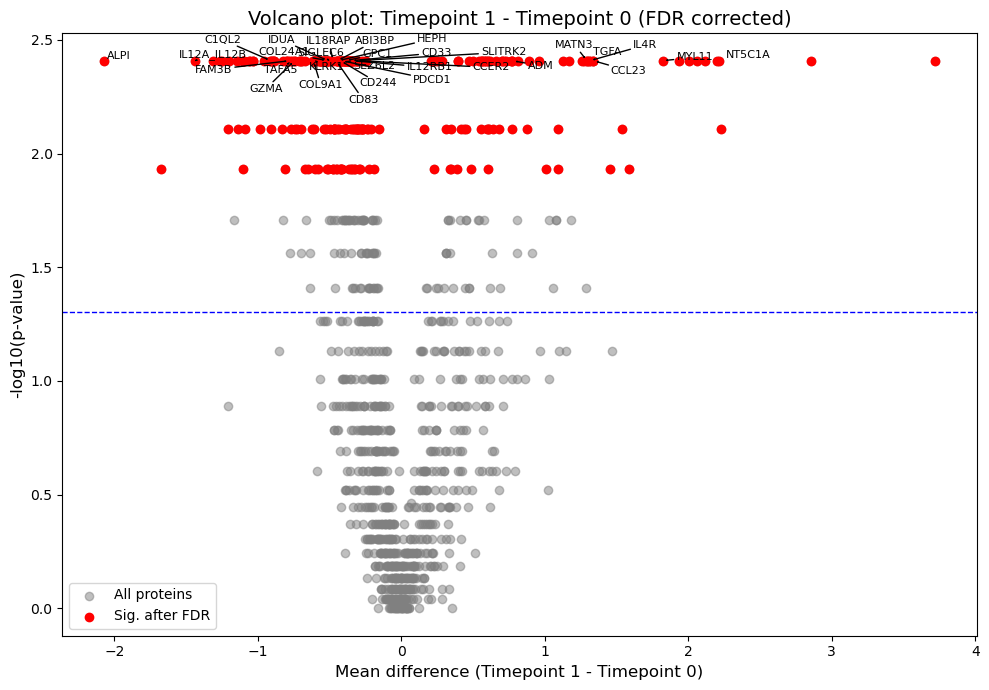

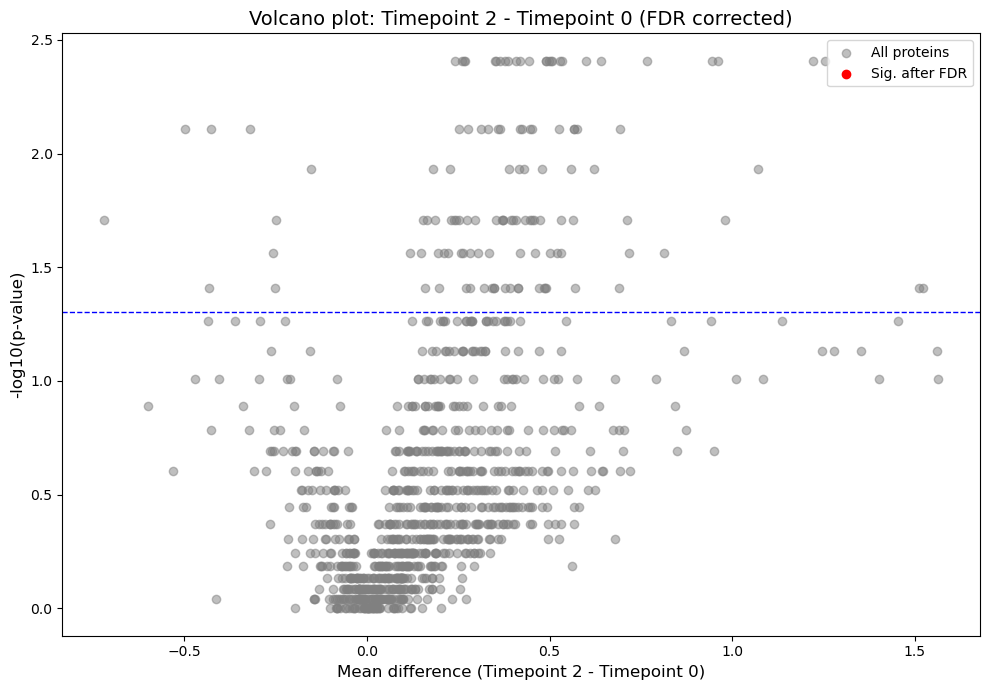

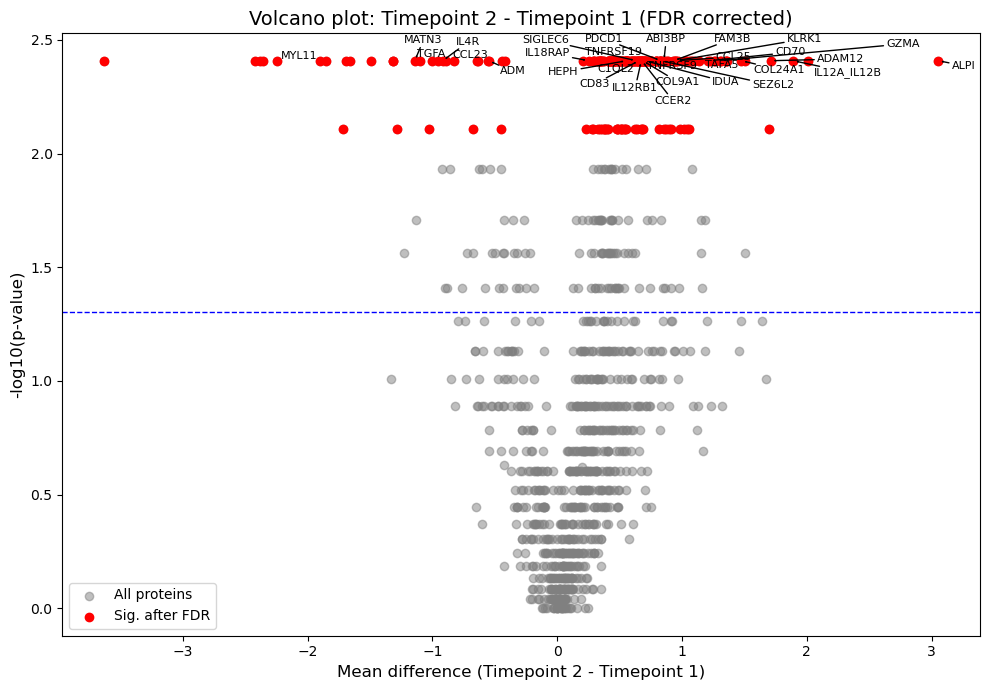

In [23]:
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np

# Define comparisons
comparisons = [
    ('p_01', 'mean_diff_01', 'Timepoint 1 - Timepoint 0'),
    ('p_02', 'mean_diff_02', 'Timepoint 2 - Timepoint 0'),
    ('p_12', 'mean_diff_12', 'Timepoint 2 - Timepoint 1')
]

for p_col, diff_col, label in comparisons:
    df_plot = results_df.dropna(subset=[p_col, diff_col])
    
    # Apply FDR correction for this pairwise test
    reject, p_fdr, _, _ = multipletests(df_plot[p_col], alpha=0.05, method='fdr_bh')
    df_plot['p_FDR'] = p_fdr
    df_plot['Sig_FDR'] = reject
    
    # Select FDR-significant proteins
    sig = df_plot[df_plot['Sig_FDR']]
    
    plt.figure(figsize=(10,7))
    plt.scatter(df_plot[diff_col], -np.log10(df_plot[p_col]), color='gray', alpha=0.5, label='All proteins')
    plt.scatter(sig[diff_col], -np.log10(sig[p_col]), color='red', label='Sig. after FDR')
    
    # Label top 30 significant proteins (based on FDR p-value)
    top_sig = sig.nsmallest(30, 'p_FDR')
    texts = []
    for _, row in top_sig.iterrows():
        texts.append(plt.text(row[diff_col], -np.log10(row[p_col]), row['Protein'], fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
    plt.xlabel(f'Mean difference ({label})', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.title(f'Volcano plot: {label} (FDR corrected)', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
